# The Data Analysis Process

### About This Notebook 

**This notebook (@author Shrihan Agarwal) is for the analysis part of the data reduction process.** This part is responsible for generating residuals, and outputting photometric and astrometric error bars for analysis. This follows directly after the earlier reduction guide. Rename this file according to the target you're performing the analysis on, Eg. analysis_OB040361.
  
The observing log for this example/template data collection (22 June, 2018) can be found at:   
https://docs.google.com/spreadsheets/d/1kyva2I7UGRoNp8cnrpHP5caPNNh-HlAsXTkEUq9DMHg/

---

## General Directory Structure

Once the entire process of data reduction is done, the directory structure might look something like the following. This might be useful to refer to.

- `2014jul14os/`
    * `@raw` (symbolic link to downloaded files)
        * Original image files (Eg. `<framename>_flip.fits`, if OSIRIS data)
        * .log file with descriptions of images
    * **`reduce/`** (create this directory, then copy over a reduce.py and analysis.py from another date, other files generated/chosen during reduction)
        * **reduce.py** (for the reduction), otherwise this notebook can replace it.
        * **analysis.py** (for the analysis), otherwise the TheCompleteAnalysisGuide.ipynb can replace it.
        * `<filter>/`
            * **sci_files directories** of objects (Eg.`sci_<target>/`)
            * **sky_files directories** of objects (Eg.`sky_<target>/`)
        * calib/
            * **darks/** directory of dark files 
            * **flats/** directory of flats
            * **masks/** directory of masks
    * **`clean/`** (create this directory, but files within are generated by reduction)
        * `<target>_<filter>/`
            * Cleaned image frames: .coo, .max, .fits (Eg. `c<framename>_flip.fits`)
            * strehl_source.txt (Descriptive file containing strehl values of individual frames)
            * distort/
            * masks/
            * weight/
    * **`combo/`** (create this directory, but files within are generated by reduction)
        * Submap files: .coo, .max, \_sig.fits, \_driz.log, .fits (Eg. `/m<date>_<target>_<filter>_<submap number>.fits`)
        * **Combined files**: .coo, .max, \_sig.fits, \_driz.log, .fits  (Eg. `/mag<date>_<target>_<desc>.fits`)
            * \_driz.log is the log generated from the stacked data 
            * \_driz.lis records all the images that went into the combined image
            * .fits is the combined/stacked final image after reduction
        * **`starfinder/`**
            * **`align/`**
            * \_stf.lis (original), \_stf_cal.lis (calibrated), \_rms_named.lis (named) - lists of stars detected by starfinder
            * plotMagError.png, plotPosError.png, plotNumStars.eps - plots of results/outputted error bars

  

`<filter>` is the name of the filter used. In the example of /20jul14os used, `<filter>` is kp_tdOpen.  
`<framename>` Eg. `i200714-a011008`, consists of `i`: image, `200714`: date, `a`: random letter, `011`: dataset number, and `008`: frame number (for OSIRIS).   
`<target>` is the name of the target. In the example of /20jul14os, it is kb200101.  
`<submap number>` is simply a number for the submap indicating which submap it is, Eg. 1  
`.coo` is the coordinates of the target in the frame (?) in x, y of the frame  
`.max` is the saturation limit, after correcting for the cleaning of the data   
`.fits` is the image file.

**Note: The naming conventions and files themselves may differ from one date/folder to another, and from OSIRIS to NIRC2 - this is just a general structure.**

For the analysis part, we'll continue working in the `reduce/` directory, but the outputs of our program are primarily in `combo/starfinder/`.

---

### Necessary Packages

#### kai

If you don't have it already, you would need to ask for access to the kai package. If you have access, ensure that it is installed on your user, and your bash profile has a PYTHONPATH to it.

You can add kai from the git repository by going to the repository you want to add kai in and performing:  

`$ git init`  
`$ git clone https://github.com/jluastro/kai`

If using OSIRIS, its very important you checkout the osiris_img branch. This branch should work for NIRC2 as well.

`$ cd kai`  
`$ git checkout osiris_img`

#### flystar

This package is on bitbucket, but as long as you don't modify it, you can simply direct your PYTHONPATH to `/u/jlu/code/python/flystar` in your bash profile.

#### microlens

This package is on GitHub. You _will_ be modifying it, so ensure that you have it cloned from GitHub similarly to kai. It is marked as private on GitHub, so you'll need permissions again.

`$ git init`    
`$ git clone https://github.com/jluastro/microlens`

You can switch to the shrih_tmp branch for a file called psflistgen.py.

---

### Before We Start - Step 0

This part of the process is largely run from the `<epoch>/reduce/analysis.py` file, which should look similar to this:

In [ ]:
from microlens.jlu import analysis

def analyze_OB040361():
    analysisObject = analysis.OB040361('18jun22', 'kp')
    analysisObject.starfinderCombo()
    analysisObject.calibrateCombo()
    analysisObject.alignCombo()
    analysisObject.analyzeCombo()
    return

There are four main functions in the analysis process, each requiring their own prerequisites:
* **starfinderCombo()** - this function runs the Starfinder tool, which can extract PSFs from a .fits image and find multiple other similar star within it. It requires a `<target>_psf.list` file to run, which will be created in Step 2.  
* **calibrateCombo()** - this function runs the photometric calibration of the image, using VVV data, for example, and uses this to calibrate the brightnesses of all the stars in the image, along with their photometric errors. It requires a `<target>_photo.dat` file to run, which will be created in Step 4. 
* **alignCombo()** - this function outputs positional error bars for the stars in the image, and puts the results of the analysis together by outputting graphs, residual plots, and more. It requires a `<target>_label.dat` file to run, which will be created in Step 6.   
* analyzeCombo() - this function simply runs all the above functions together, in the case that the entire analysis process needs to be redone.

### Creating an Analysis Class for A New Target - Step 1

The first step is to create a new analysis class in the microlens package pulled from GitHub. Open the `microlens/jlu/analysis.py` file and copy over this template after replacing the \<target> or \<TARGET> with your target name, eg. ob040361 or OB040361. Other examples are also present in the analysis.py file. This set of instance variables generally works, but if not, it may only be confirmed after finishing the whole analysis process and viewing the plotPosError.png and other files that aare generated. 

In [ ]:
class <TARGET>(analysis.Analysis):
    def __init__(self, epoch, filt, rootDir='/u/jlu/data/microlens/',
                 epochDirSuffix=None, imgSuffix=None, cleanList='c.lis', alignMagCut=' -m 20 ',
                 instrument=instruments.default_inst):
        """
        For <TARGET> reduction:

        epoch -- '11may' for example
        filt -- 'kp', 'lp', or 'h'
        """
        filt_field = '<target>_' + filt

        # Initialize the Analysis object
        analysis.Analysis.__init__(self, epoch, filt=filt_field,
                                     rootDir=rootDir,
                                     epochDirSuffix=epochDirSuffix, imgSuffix=imgSuffix,
                                     cleanList=cleanList, instrument=instrument) #, mode='single')

        # Use the field to set the psf starlist
        self.starlist = self.rootDir + 'source_list/<target>_psf.list'

        # Set up some extra starfinder keywords to optimize PSF handling.
        self.stf_extra_args = ', psfSize=2.0, trimfake=0' # 2 arcsec
        self.corrMain = 0.7
        self.corrSub = 0.5

        ##########
        # Setup the appropriate calibration stuff.
        ##########
        self.mapFilter2Cal = {'kp': 'Ks_VVV', 'h': 'H', 'j': 'J'}
        
        # Use the default stars
        self.calStars = None

        # Choose the column based on the filter
        self.calColumn = self.mapFilter2Cal[filt]

        # Set the coo star
        self.cooStar = '<target>'
        self.calCooStar = self.cooStar

        # Override some of the default parameters
        self.calFlags = '-f 1 -R -s 1 --searchMag=2.0 '
        self.calFile = self.rootDir + 'source_list/<target>_photo.dat'

        self.labellist = self.rootDir + 'source_list/<target>_label.dat'
        self.orbitlist = None

        # Fix align flags. Otherwise, align is using too many faint stars.
        self.alignFlags = '-R 3 -v -p -a 2 ' + alignMagCut

        self.plotPosMagCut = 20.0

        return

### Using PrepAnalysis To Create A PSF List - Step 2

Import the following packages:

In [1]:
import numpy as np
from astropy import table
from datetime import date
from astropy.io import ascii
import os
from kai.reduce import prep_analysis

Run this method for the list generation. Examples of other kwargs that can be added are commented below.

PSF Stars Found: 21/7
Returning Best: 7
*************************************************
PSF List Details: 
   x      y      peak    m    mx     my  
------- ------ -------- --- ------ ------
 560.25 560.51 28908.58   1    0.0    0.0
 208.32 971.75  9486.96   1    0.0    0.0
 512.56 239.18  1861.56   1    0.0    0.0
 441.21 404.77  1200.21   1    0.0    0.0
1045.33 384.63    875.7   1    0.0    0.0
 244.97 416.75    568.5   1    0.0    0.0
 835.08  619.3   460.68   1    0.0    0.0
 644.14 554.03   371.01   0 560.25 560.51
 468.71 423.02   324.72   0 441.21 404.77
*************************************************
PSFListGen Identified the Following List of Stars:
[
   [560.25, 560.51, 1],
   [208.32, 971.75, 1],
   [512.56, 239.18, 1],
   [441.21, 404.77, 1],
   [1045.33, 384.63, 1],
   [244.97, 416.75, 1],
   [835.08, 619.3, 1],
   [644.14, 554.03, 0],
   [468.71, 423.02, 0],
]
*************************************************


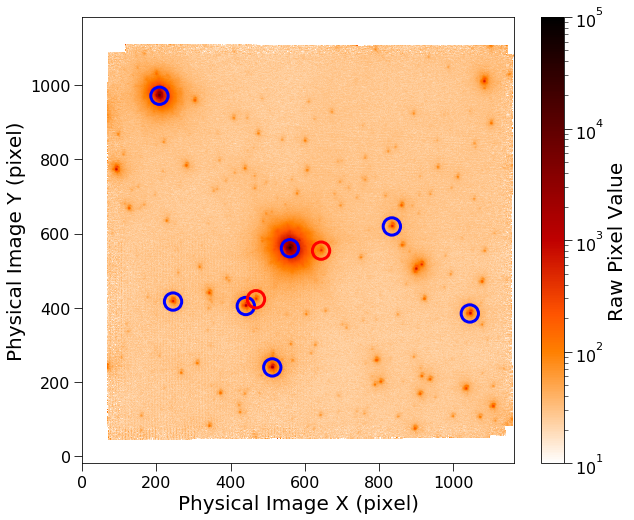

In [2]:
# Structure: prep_analysis.generate_list(
    # path to file, 
    # numPSFStars = (number of stars to get),
    # fwhm = (full width half max to try, in pixels),
    # target = (says name of target in plot),
    # scale = (scale of telescope in arcsec/pixel, defaults to 0.009942))
    
prep_analysis.generate_list("/g/lu/data/microlens/18jun22/combo/mag18jun22_ob040361_kp.fits")

# Other examples:
# prep_analysis.generate_list("/g/lu/data/microlens/18jun22/combo/mag18jun22_ob040361_kp.fits", numPSFStars = 12)
# prep_analysis.generate_list("/g/lu/data/microlens/18jun22/combo/mag18jun22_ob040361_kp.fits", scale = 0.020)
# prep_analysis.generate_list("/g/lu/data/microlens/18jun22/combo/mag18jun22_ob040361_kp.fits", fwhm = 5)
# prep_analysis.generate_list("/g/lu/data/microlens/18jun22/combo/mag18jun22_ob040361_kp.fits", target = "ob040361")

A good psf.list has the following characteristics:
* The main target is chosen.
* The brightest stars in the image are chosen.
* Stars chosen don't have other stars too near them.
* If a star is nearby but not too close, mark it as a secondary (0), to be ignored during psf extraction.
* Stars chosen should not be too close to the edge.
* Stars chosen should not be a "halo speckle" (within psf of bright star).

Copy the list (x, y, PSF?) and save it in the variable below. If any stars seem incorrect, or secondaries need to be added, or if it didn't work and needs to be manually done, you can open SAOImageDS9, find the star's pixel positions and add them below here. Secondaries (stars to be ignored) are 0, and stars to be chosen are 1.

In [6]:
psfStars = [
                [560.25, 560.51, 1],  # Target Itself
                [208.32, 971.75, 1],  # Second brightest, top right star
                [512.56, 239.18, 1],  # Bright, bottom star
                [441.21, 404.77, 1],  # Bottom left of target, brighter of the two nearby stars
                [1045.33, 384.63, 1], # Bright star on right side 
                [244.97, 416.75, 1],  # Another bright left star 
                [835.08, 619.3, 1],   # To the right of target
                [644.14, 554.03, 0],  # Secondary near target psf
                [468.71, 423.02, 0],  # Other nearby secondary star to above star
           ]

Then, run this prepStarfinder command which takes this psfList and makes it into a \_psf.list file! The directory that you would want to place this in if working on the main computers is `/g/lu/data/microlens/source_list/`. It will save the file as `<target>_psf.list`.

In [ ]:
# Structure: .prepStarfinder(dirName, targetName, targetCoords, psfStarCoords, filterName)
prep_analysis.prepStarfinder('/g/lu/data/microlens/source_list/', 'ob040361', psfStars[0], psfStars, 'Kp')

Then, you're all set to start running the analysis.py file! 

### Running Starfinder - Step 3

Your `<target>/reduce/analysis.py` file should look similar to the below, with OB040361 replaced instead by your target name. This method essentially takes the Step 1 class and instantiates it, followed by running some functions on it.

In [ ]:
from microlens.jlu import analysis

def analyze_OB040361():
    analysisObject = analysis.OB040361('18jun22', 'kp')
    analysisObject.starfinderCombo()
    #analysisObject.calibrateCombo()
    #analysisObject.alignCombo()
    #analysisObject.analyzeCombo()
    return

The first of these functions is starfinderCombo(). Comment out the remaining functions and run this in ipython, in the terminal:

`$ ipython`  
`>>> import analysis`  
`>>> analysis.analyze_OB040361()`

This begins running Starfinder, which uses IDL to run. Because of this, you will not see output in the terminal window! Navigate to the `<target>/combo/starfinder/idlbatch_combo_<target>_kp.log` directory to see starfinder running. It will take 20-40 minutes to run, and the .log file might end with an error. This should be alright.

Check in the same directory for a `mag<date>_<target>_kp_<corrMain>_stf.lis` file. This has all the stars that starfinder was able to detect using its powerful psf extraction technique. We'll be using this in the following section. Here is an example excerpt:

In [ ]:
ob040361   9.000  2018.473  560.23798  560.53400   66012.03   0.99      29        5984690
star_1    10.198  2018.473  208.27800  971.78601   21872.44   0.99      29        1984830
star_2    12.014  2018.473  512.54797  239.21300   4100.26    0.99      29         372788
star_3    12.504  2018.473  441.19000  404.79099   2617.69    0.99      29         237485
star_4    12.823  2018.473 1045.32996  384.65799   1950.18    0.99      30         176920
star_5    12.997  2018.473   92.22560  771.91998   1660.01    0.99       9         150699
star_6    13.234  2018.473  899.96198  504.26901   1122.28    0.99      29         121199
star_7    13.275  2018.473 1083.19995 1009.07001   1284.97    0.99      30         116733
star_8    13.310  2018.473  244.98199  416.78201   1246.09    0.99      29         113002
star_9    13.537  2018.473  835.06702  619.28497   1007.98    0.99      29          91670
...

From left to right, the columns are Name, Magnitude, Epoch, Pixel X, Pixel Y, Signal-Noise Ratio, Corr, Num_Frames and Flux.

### Photometric Recalibration - Step 4

Import the necessary modules:

In [19]:
from astroquery.mast import Observations, Catalogs 
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
from astroquery.vsa import Vsa
from astropy import units as u
import numpy as np
import pylab as plt
from astropy import table
from flystar import starlists, align, match
from flystar import transforms
from flystar import analysis, plots
from kai.reduce import prep_analysis
from microlens.jlu import align_flystar
from importlib import reload

Save the target name and RA/Dec coordinates (hh:mm:ss) in variables to be used later on.

In [20]:
target = 'ob040361'
ra = '17:46:35.41'
dec = '-33:46:19.7'

Seach the ESO Database for area near the target star and pull the data for all nearby stars from the VVV survey's database, which will be used for comparison.  
This will be saved in the sourceTable variable, and it has all the photometric data of nearby sources to the target coords specified. Also, the target_coords is a SkyCoords object holds the coordinates and helps us with unit conversions, etc.

In [21]:
target_coords = SkyCoord(ra, dec, unit=(u.hourangle, u.deg), frame='icrs')
search_rad = 0.25 * u.arcmin


sourceTable = Vsa.query_region(target_coords, radius=search_rad, programme_id='VVV', database='VVVDR4')
print(sourceTable.colnames)
print(sourceTable[0:5])

['sourceID', 'cuEventID', 'frameSetID', 'ra', 'dec', 'cx', 'cy', 'cz', 'htmID', 'l', 'b', 'lambda', 'eta', 'priOrSec', 'zmyPnt', 'zmyPntErr', 'ymjPnt', 'ymjPntErr', 'jmhPnt', 'jmhPntErr', 'hmksPnt', 'hmksPntErr', 'mergedClassStat', 'mergedClass', 'pStar', 'pGalaxy', 'pNoise', 'pSaturated', 'zAperMag1', 'zAperMag1Err', 'zAperMag3', 'zAperMag3Err', 'zAperMag4', 'zAperMag4Err', 'zGausig', 'zEll', 'zPA', 'zErrBits', 'zAverageConf', 'zClass', 'zClassStat', 'zppErrBits', 'zSeqNum', 'zXi', 'zEta', 'yAperMag1', 'yAperMag1Err', 'yAperMag3', 'yAperMag3Err', 'yAperMag4', 'yAperMag4Err', 'yGausig', 'yEll', 'yPA', 'yErrBits', 'yAverageConf', 'yClass', 'yClassStat', 'yppErrBits', 'ySeqNum', 'yXi', 'yEta', 'jAperMag1', 'jAperMag1Err', 'jAperMag3', 'jAperMag3Err', 'jAperMag4', 'jAperMag4Err', 'jGausig', 'jEll', 'jPA', 'jErrBits', 'jAverageConf', 'jClass', 'jClassStat', 'jppErrBits', 'jSeqNum', 'jXi', 'jEta', 'hAperMag1', 'hAperMag1Err', 'hAperMag3', 'hAperMag3Err', 'hAperMag4', 'hAperMag4Err', 'hGausi

These are some of the table columns we'll be using.

In [22]:
sourceTable['ra', 'dec', 'ksAperMag1', 'ksAperMag1Err'][0:5]

ra,dec,ksAperMag1,ksAperMag1Err
float64,float64,float32,float32
266.64410181391787,-33.77144151834791,14.993253,0.04827977
266.6460821252096,-33.769561113372596,16.664467,0.22228283
266.64345358685756,-33.771223786340855,15.370311,0.06801036
266.64514349185646,-33.77159240532347,15.165481,0.056448188
266.6522230286752,-33.770705134248765,12.884358,0.007537585


Finding the target in the VVV4 database and confirming it is indeed the right target. These coordinates will be used for normalization to target instad of the OGLE coordinates due to slight discrepancies between them. 

In [23]:
# VVV4 COORDINATES OF OB040361: 266.64773351 = 17:46:35.448
# OGLE COORDINATES OF OB040361:                17:46:35.41 
targTable = Vsa.query_region(target_coords, radius= 1 * u.arcsec, programme_id='VVV', database='VVVDR4')
x = targTable["ra"][0]
y = targTable["dec"][0]
v4_coords = SkyCoord(x, y, unit=(u.deg, u.deg), frame='icrs')
print(v4_coords)
print(target_coords)

<SkyCoord (ICRS): (ra, dec) in deg
    (266.64773351, -33.77215774)>
<SkyCoord (ICRS): (ra, dec) in deg
    (266.64754167, -33.77213889)>


Next, we change the catalog RA/Dec according to their offsets from the main target itself, and get the result in arcsec. Now we have the Dec and RA relative to the target star. The multiplication by u.degree tells astropy its in degrees, and then we can do subtractions, etc. Also, converting is super easy! Just take d_dec, for example, and add .arcsec! No clue how many instance variables they store for this but makes life easy :)

In [24]:
d_dec = sourceTable['dec']*u.degree - v4_coords.dec
print(d_dec[0:5])
print(d_dec.arcsec[0:5])

[0d00m02.5784s 0d00m09.3478s 0d00m03.3622s 0d00m02.0352s 0d00m05.2294s]
[2.57839171 9.34784962 3.36222693 2.0351986  5.22937447]


Similarly for RA. The multiplication by cos(dec) is required to transform from spherical to a plane projection such as the image.

In [25]:
d_ras = (sourceTable['ra']*u.degree - v4_coords.ra) * np.cos(v4_coords.dec.radian)

print(d_ras[0:5])
print(d_ras.arcsec[0:5])

[-0d00m10.8679s -0d00m04.9418s -0d00m12.8077s -0d00m07.7507s 0d00m13.435s]
[-10.86789991  -4.94178489 -12.80773035  -7.75066107  13.43497257]


Then, we add this newly made d_dec and d_ras to the sourceTable. We can also do `d_dec.arcsec`  directly, but here let's opt for `to_value()` for a bit of variety. Good to know we can access these conversions with both methods and instance variables.

In [26]:
sourceTable['d_dec'] = d_dec.to_value('arcsec')
sourceTable['d_ras'] = d_ras.to_value('arcsec')

Next, we take the `_stf.lis` file generated in the previous step and read it into an astropy table. Then, we reformat it so our plot_starlist_on_image function can handle it. 

In [27]:
# Plot the NIRC2 image with the label.dat list on top of it.
nirc2_label_file = "/g/lu/data/microlens/18jun22/combo/starfinder/mag18jun22_ob040361_kp_0.7_stf.lis"
nirc2_label = table.Table.read(nirc2_label_file, format = "ascii", names = ("name",
                                                                            "m",
                                                                            "t0",
                                                                            "Xpix",
                                                                            "Ypix",
                                                                            "snr?",
                                                                            "corr?",
                                                                            "frames?",
                                                                            "flux?"))
print(nirc2_label)
nirc2_label["x"] = np.round((np.array(nirc2_label["Xpix"][:]) - (nirc2_label["Xpix"][0])) * (-9.942 / 1000), 4)
nirc2_label["y"] = np.round((np.array(nirc2_label["Ypix"][:]) - (nirc2_label["Ypix"][0])) * (9.942 / 1000), 4)
plotter_list = nirc2_label["name", "m", "x", "y"]
print("***********************************************")
print(plotter_list)



  name     m       t0       Xpix       Ypix      snr?   corr? frames?  flux? 
-------- ------ -------- ---------- ---------- -------- ----- ------- -------
ob040361    9.0 2018.473  560.23798    560.534 66012.03  0.99      29 5984690
  star_1 10.198 2018.473    208.278  971.78601 21872.44  0.99      29 1984830
  star_2 12.014 2018.473  512.54797    239.213  4100.26  0.99      29  372788
  star_3 12.504 2018.473     441.19  404.79099  2617.69  0.99      29  237485
  star_4 12.823 2018.473 1045.32996  384.65799  1950.18  0.99      30  176920
  star_5 12.997 2018.473    92.2256  771.91998  1660.01  0.99       9  150699
  star_6 13.234 2018.473  899.96198  504.26901  1122.28  0.99      29  121199
  star_7 13.275 2018.473 1083.19995 1009.07001  1284.97  0.99      30  116733
  star_8  13.31 2018.473  244.98199  416.78201  1246.09  0.99      29  113002
  star_9 13.537 2018.473  835.06702  619.28497  1007.98  0.99      29   91670
     ...    ...      ...        ...        ...      ...   ...   

This method is in microlens/jlu/prep_analysis.py, even though it is unrelated to the psflist. The detailed docstring is in the package file. Simply, the coordinates are the coordinates of the target, flip flips the image, label adds labels, magCut cuts the magnitude off beyond a desired magnitude, and verbose prints the table.

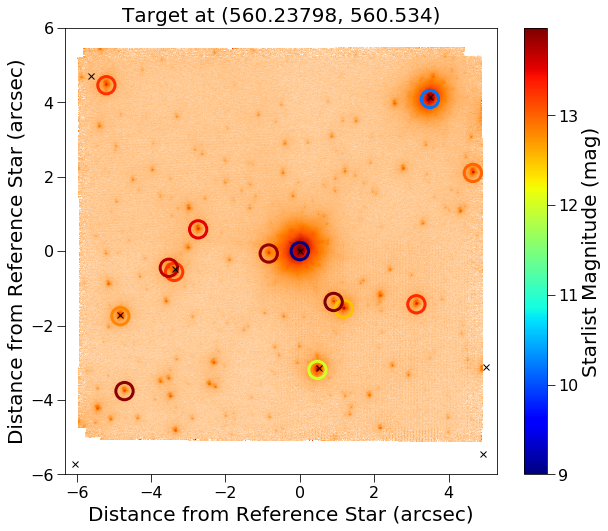

In [28]:
prep_analysis.plot_starlist_on_image_arcsec(plotter_list, 
                                          "/g/lu/data/microlens/18jun22/combo/mag18jun22_ob040361_kp.fits", 
                                          (560.23798, 560.534),
                                          flip = True, 
                                          label = False, 
                                          magCut = 14, 
                                          verbose = False)
plt.xlim(-6, 5)
plt.ylim(-6, 6)
plt.plot(sourceTable["d_ras"], sourceTable["d_dec"], "kx")

Here, we overlayed the starfinder stars (o) as well as the VVV4 stars (x) on the nirc2 image. We should avoid double stars, i.e stars where VVV4 has marked two of as a single star. An example of this is in the above image, where VVV4 has marked two stars as one - this would incorrectly calibrate the photometry. Check that the VVV4 matches with the nirc2 data. If there's an issue, check that the image North and East and VVV4 North and East are pointing in the same direction.

The below code matches a star to the VVV4 data if it seems to be located nearby, and calibrates it's magnitude accordingly. The magnitude tolerance is high since the nirc2/osiris flux data may not be very accurate.

In [11]:
gdx = np.where(nirc2_label['m'] < 13)[0]
nirc2_label_g = nirc2_label[gdx]
ndx_g, ndx_n, dr, dm = match.match(sourceTable["d_ras"], sourceTable["d_dec"], sourceTable["ksAperMag3"],
                                   nirc2_label_g["x"], nirc2_label_g["y"], nirc2_label_g["m"],
                                  dr_tol = 1.0, dm_tol = 10)

nirc2_match = nirc2_label_g[ndx_n]
sourceTable_match = sourceTable[ndx_g]

print(ndx_g)
print(nirc2_match['name', 'x', 'y', 'm'])

    Found 0 duplicates out of 4 matches
[ 8 25 35 36]
  name      x       y      m   
-------- ------- ------- ------
  star_2  0.4741 -3.1946 12.014
  star_4 -4.8228 -1.7486 12.823
ob040361    -0.0     0.0    9.0
  star_1  3.4992  4.0887 10.198


The following steps are to make this matched table into a photo.dat list, which will be used by the next step in the analysis.py file to photometrically calibrate the image.

In [12]:
def replaceStarWithS00(lst):
    lnew = []
    for s in lst:
        if s.find("star") >= 0:
            s = s.replace("star_", "")
            s_new = "S"
            for i in range(3 - len(s)):
                s_new += "0"
            lnew.append(s_new + s)
        else:
            lnew.append(s)
    return lnew

In [13]:
nirc2_match["name"] = replaceStarWithS00(nirc2_match["name"][:])
nirc2_match["name"]

S002
S004
ob040361
S001


This is a template photo.dat file which we will use to make the new one (which is used to do calibration). So do not replace the ob120169 with the target in this case.

In [14]:
nirc2_calib_file = '/g/lu/data/microlens/source_list/' + "ob120169" + '_photo.dat'
calib = table.Table.read(nirc2_calib_file, format='ascii.commented_header', delimiter='\s', header_start=-1)
print(calib)

    Star    x_pos  y_pos  x_vel y_vel ... H_err  J   J_err Ks_VVV Ks_VVV_err
----------- ------ ------ ----- ----- ... ----- ---- ----- ------ ----------
p000_16_3.6    0.0    0.0   0.0   0.0 ...   0.0 17.0   0.0  16.38        0.1
p005_15_3.5 -0.536 -6.917   0.0   0.0 ...   0.0 17.0   0.0 15.728      0.054
  S2_16_2.5  2.196  1.594   0.0   0.0 ...   0.0  0.0   0.0 16.201      0.082
  S8_17_3.0 -2.339 -1.685   0.0   0.0 ...   0.0  0.0   0.0 16.905      0.156


In [15]:
print('****************************')
print('* TEMPLATE PHOTO.DAT TABLE *')
print('****************************')

# Flag to track whether VVVdr4 is in this file.
found_vvv_dr4 = False

for cc in calib.meta['comments']:
    print(cc)
calib.pprint(max_width=-1)

****************************
* TEMPLATE PHOTO.DAT TABLE *
****************************
# Version: 2020_08_18
# Analysis: /u/jlu/work/microlens/OB120169/a_2020_08_18/notes/1_recalibrate.ipynb
# Columns: Format of this header is hardcoded for read in by calibrate.py
# Field separator in each column is "--". Default calibrators are listed after
# each magnitude column header entry.
1 -- Star Name
2 -- X position (arcsec, increasing to the East)
3 -- Y position (arcsec)
4 -- X velocity (mas/yr)
5 -- Y velocity (mas/yr)
6 -- t0 (year)
7 -- Variable? flag
Bandpass Calibration Details:
Default calibrators are listed after each magnitude column header entry.
Error column indicates uncertainties in the reference magnitude for star (older calibrations did not use this)
Filt -- K: K band (2MASS) -- p000_16_3.6,p005_15_3.5
Filt -- H: H band (2MASS) -- p000_16_3.6,p005_15_3.5
Filt -- J: J band (2MASS) -- p000_16_3.6,p005_15_3.5
Filt -- Ks_VVV: Ks band (VVVdr4) -- S2_16_2.5,S8_17_3.0,p005_15_3.5
   

We are replacing parts of the above template to make a new photo.dat file that will be used in the next step of our analysis process. Depending on the target, you'll need to modify how the photo.dat table is modified, but the key points are that the version, header, Filt -- ..., and the stars themselves have to be replaced. An example of this is below.

In [16]:
from datetime import date
from astropy.io import ascii

today = date.today()
dt = today.strftime("%Y_%m_%d")
calib.meta["comments"][0] = "# Version: " + dt
calib.meta['comments'][1] = '# Analysis: /u/shrih/work/JupyterNotes/TheARGuide.ipynb' # Replace this!

In [17]:
# Getting the reference stars (i.e. non-target matched stars) and 
# joining them in a string to replace the Filt -- ... part
not_targ = np.where(nirc2_match['name'] != target)[0]
ref_stars_str = ','.join(nirc2_match['name'][not_targ])

# In this case, the filter is Ks_VVV (since we are using VVV to calibrate). So create this column.
calib['Ks_VVV']= 0.0
calib['Ks_VVV_err'] = 0.0

# Create new comment in header with refstars for this filter
new_comm = 'Filt -- Ks_VVV: Ks band (VVVdr4) -- ' + ref_stars_str

# Remove other filter comments and add this one
for i in range(4):
    calib.meta['comments'].pop()
calib.meta['comments'].append(new_comm)

# Remove template stars from table
calib.remove_rows([0, 1, 2, 3])

# Add the new stars, and set their magnitudes and errors to the Ks_VVV data
for ss in range(len(nirc2_match)):
    sdx = np.where(calib['Star'] == nirc2_match['name'][ss])[0]
    
    if len(sdx) == 1:
        star = sdx[0]
        
        calib['Ks_VVV'][star] = sourceTable_match['ksAperMag1'][ss]
        calib['Ks_VVV_err'][star] = sourceTable_match['ksAperMag1Err'][ss]
    else:
        calib.add_row()
        star = -1
        calib['Star'][star] = nirc2_match['name'][ss]
        calib['x_pos'][star] = nirc2_match['x'][ss]
        calib['y_pos'][star] = nirc2_match['y'][ss]
        calib['Ks_VVV'][star] = sourceTable_match['ksAperMag1'][ss]
        calib['Ks_VVV_err'][star] = sourceTable_match['ksAperMag1Err'][ss]
        
        
calib['Star'].format = '{:<13s}'
calib['x_pos'].format = '{:6.3f}'
calib['y_pos'].format = '{:6.3f}'
calib['x_vel'].format = '{:6.3f}'
calib['y_vel'].format = '{:6.3f}'
calib['t0'].format = '{:7.2f}'
calib['var?'].format = '{:1d}'

calib['J'].format = '{:6.3f}'
calib['H'].format = '{:6.3f}'
calib['K'].format = '{:6.3f}'
calib['Ks_VVV'].format = '{:6.3f}'

calib['J_err'].format = '{:5.3f}'
calib['H_err'].format = '{:5.3f}'
calib['K_err'].format = '{:5.3f}'
calib['Ks_VVV_err'].format = '{:5.3f}'
    
print('*************')
print('* NEW TABLE *')
print('*************')

for cc in calib.meta['comments']:
    print(cc)
calib.pprint(max_width=-1)

*************
* NEW TABLE *
*************
# Version: 2020_12_24
# Analysis: /u/shrih/work/JupyterNotes/TheARGuide.ipynb
# Columns: Format of this header is hardcoded for read in by calibrate.py
# Field separator in each column is "--". Default calibrators are listed after
# each magnitude column header entry.
1 -- Star Name
2 -- X position (arcsec, increasing to the East)
3 -- Y position (arcsec)
4 -- X velocity (mas/yr)
5 -- Y velocity (mas/yr)
6 -- t0 (year)
7 -- Variable? flag
Bandpass Calibration Details:
Default calibrators are listed after each magnitude column header entry.
Error column indicates uncertainties in the reference magnitude for star (older calibrations did not use this)
Filt -- Ks_VVV: Ks band (VVVdr4) -- S002,S004,S001
     Star     x_pos  y_pos  x_vel  y_vel     t0   var?   K    K_err   H    H_err   J    J_err Ks_VVV Ks_VVV_err
------------- ------ ------ ------ ------ ------- ---- ------ ----- ------ ----- ------ ----- ------ ----------
S002           0.474 -3.19

Now, all we need to do is write this table into a new photo.dat file. In general, this should also go into the same `source_list/` directory as our psf list, since this is where the packages pull the data from.

In [18]:
calib_file = "/g/lu/data/microlens/source_list/" + target + "_photo.dat"


_out = open(calib_file, 'w+')
for cc in calib.meta['comments']:
    if cc.startswith("#"):
        _out.write('#' + cc + '\n')
    else:
        _out.write('# ' + cc + '\n')


del calib.meta['comments']
_out.write('#')
ascii.write(calib, _out, format='fixed_width', delimiter=' ', bookend=False)
_out.close()

Now, we can begin the next step of the calibration process, which uses our calibration stars as specified in photo.dat, and converts the `mag<date>_<target>_kp_<corrMain>_stf.lis` file into a `mag<date>_<target>_kp_<corrMain>_stf_cal.lis` file, which is the equivalent, but calibrated. This will be done in the next step.

In [19]:
!cat $calib_file

## Version: 2020_12_24
## Analysis: /u/shrih/work/JupyterNotes/TheARGuide.ipynb
## Columns: Format of this header is hardcoded for read in by calibrate.py
## Field separator in each column is "--". Default calibrators are listed after
## each magnitude column header entry.
# 1 -- Star Name
# 2 -- X position (arcsec, increasing to the East)
# 3 -- Y position (arcsec)
# 4 -- X velocity (mas/yr)
# 5 -- Y velocity (mas/yr)
# 6 -- t0 (year)
# 7 -- Variable? flag
# Bandpass Calibration Details:
# Default calibrators are listed after each magnitude column header entry.
# Error column indicates uncertainties in the reference magnitude for star (older calibrations did not use this)
# Filt -- Ks_VVV: Ks band (VVVdr4) -- S002,S004,S001
#         Star    x_pos    y_pos    x_vel    y_vel        t0   var?        K   K_err        H   H_err        J   J_err   Ks_VVV   Ks_VVV_err
S002             0.474   -3.195    0.000    0.000      0.00      0    0.000   0.000    0.000   0.000    0.000   0.000   14.5

### Running the Photometric Calibration Process - Step 5

This is a quick and easy step. Comment out the other lines in the `<epoch>/reduce/analysis.py` file like below and simply run calibrateCombo() from ipython, similarly to how you ran starfinderCombo(). Check `<epoch>/combo/starfinder/` for a new stf_cal.lis file, with the stars photometrically calibrated. That's all for this step. 

In [20]:
from microlens.jlu import analysis

def analyze_OB040361():
    #analysisObject = analysis.OB040361('18jun22', 'kp')
    #analysisObject.starfinderCombo()
    analysisObject.calibrateCombo()
    #analysisObject.alignCombo()
    #analysisObject.analyzeCombo()
    return

`$ ipython`  
`>>> import analysis`  
`>>> analysis.analyze_OB040361()`

An excerpt of the now calibrated file:

In [ ]:
ob040361  11.267208  2018.473   560.23798   560.53400       23.39       0.99        29    5984690.000
S002      14.281208  2018.473   512.54797   239.21300       23.39       0.99        29     372788.000
S004      15.090208  2018.473  1045.32996   384.65799       23.39       0.99        30     176920.000
S001      12.465208  2018.473   208.27800   971.78601       23.39       0.99        29    1984830.000
star_3    14.771208  2018.473   441.19000   404.79099       23.39       0.99        29     237485.000
star_5    15.264208  2018.473    92.22560   771.91998       23.39       0.99         9     150699.000
star_6    15.501208  2018.473   899.96198   504.26901       23.38       0.99        29     121199.000
star_7    15.542208  2018.473  1083.19995  1009.07001       23.39       0.99        30     116733.000
star_8    15.577208  2018.473   244.98199   416.78201       23.39       0.99        29     113002.000
star_9    15.804208  2018.473   835.06702   619.28497       23.38       0.99        29      91670.000
star_10   15.988208  2018.473   914.29901   515.37097       23.38       0.99        30      77377.000

### Creating a Labeled List - Step 6

We now have to take the `mag<date>_<target>_kp_<corrMain>_stf_cal.lis` file that we generated and use it to make a `label.dat` file, similarly to how we generated photo.dat and saved it in the `source_list/` directory. We first read in the `stf_cal.lis` file. 

In [22]:
calStfLisPath = "/g/lu/data/microlens/18jun22/combo/starfinder/mag18jun22_ob040361_kp_0.7_stf_cal.lis"
calStfLis = align_flystar.starlists.read_starlist(calStfLisPath, error=False)
calStfLis

name,m,t,x,y,snr,corr,N_frames,flux
str8,float64,float64,float64,float64,float64,float64,int64,float64
ob040361,11.267208,2018.473,560.23798,560.534,23.39,0.99,29,5984690.0
S002,14.281208,2018.473,512.54797,239.213,23.39,0.99,29,372788.0
S004,15.090208,2018.473,1045.32996,384.65799,23.39,0.99,30,176920.0
S001,12.465208,2018.473,208.278,971.78601,23.39,0.99,29,1984830.0
star_3,14.771208,2018.473,441.19,404.79099,23.39,0.99,29,237485.0
star_5,15.264208,2018.473,92.2256,771.91998,23.39,0.99,9,150699.0
star_6,15.501208,2018.473,899.96198,504.26901,23.38,0.99,29,121199.0
star_7,15.542208,2018.473,1083.19995,1009.07001,23.39,0.99,30,116733.0
star_8,15.577208,2018.473,244.98199,416.78201,23.39,0.99,29,113002.0


We want to make a table in the same format to other label.dat files, for example,

In [ ]:
!more $"/g/lu/data/microlens/source_list/ob020061_label.dat"

# name             kp        xarc       yarc   xerr   yerr         vx         vy     vxerr     vyerr         t0   use      r2d
ob020061       13.187       0.000      0.000      0      0          0          0         0         0          0     8        0
S01_16_3.4     16.072      -0.528     -3.335      0      0          0          0         0         0          0     8    3.377
S02_13_3.0     15.393      -2.843      0.674      0      0          0          0         0         0          0     8    2.922
S03_16_2.4     16.217       3.940     -1.325      0      0          0          0         0         0          0     8    4.157
S04_15_2.7     14.626      -0.652      4.233      0      0          0          0         0         0          0     8    4.283
/g/lu/data/microlens/source_list/ob020061_label.dat (END)

where xarc, yarc, r2d is relative x, y, euclidean distance to target in arcsec, xerr and yerr are the position errors, vx and vy are the velocity and vxerr and vyerr their error, and t0 is the epoch. (use is not applicable for this part of the pipeline and can simply be set to 1). Since we are doing a new target, we do not have to deal with the velocity, and so those the errors can be set to 0 for now, since they will be filled in by the alignCombo() run (next step).

In [ ]:
calStfLis["xarc"] = (calStfLis["x"] - calStfLis["x"][0]) * (-9.942 / 1000) # This is relative distance to target in x
calStfLis["yarc"] = (calStfLis["y"] - calStfLis["y"][0]) * (9.942 / 1000)  # This is relative distance to target in y
calStfLis["r2d"] = np.round(np.sqrt((calStfLis["xarc"] ** 2) +  (calStfLis["yarc"] ** 2)), 4) # Euclidean distance
calStfLis["xarc"] = np.round(calStfLis["xarc"], 4)
calStfLis["yarc"] = np.round(calStfLis["yarc"], 4)

In [25]:
calStfLis["xerr"] = 0.0
calStfLis["yerr"] = 0.0
calStfLis["vx"] = 0.0
calStfLis["vy"] = 0.0
calStfLis["vxerr"] = 0.0
calStfLis["vyerr"] = 0.0
calStfLis["use"] = 1
calStfLis.rename_column("m", "kp")
calStfLis.rename_column("t", "t0")

In [26]:
calStfLis = calStfLis["name", "kp", "xarc", "yarc", 
                      "xerr", "yerr", "vx", 
                      "vy", "vxerr", "vyerr",
                     "t0", "use", "r2d"]

We also need to rename the stars from "star_" since this kind of name implies the star is unknown or to be ignored by the program.

In [27]:
calStfLis["name"] = replaceStarWithS00(calStfLis["name"])

After our modifications to the table pulled from `cal_stf.lis`, our table perfectly matches the label.dat template which the next step in the process needs to run.

In [28]:
calStfLis.pprint()

  name       kp      xarc    yarc  xerr yerr ... vxerr vyerr    t0    use  r2d  
-------- --------- ------- ------- ---- ---- ... ----- ----- -------- --- ------
ob040361 11.267208    -0.0     0.0  0.0  0.0 ...   0.0   0.0 2018.473   1    0.0
    S002 14.281208  0.4741 -3.1946  0.0  0.0 ...   0.0   0.0 2018.473   1 3.2296
    S004 15.090208 -4.8228 -1.7486  0.0  0.0 ...   0.0   0.0 2018.473   1   5.13
    S001 12.465208  3.4992  4.0887  0.0  0.0 ...   0.0   0.0 2018.473   1 5.3816
    S003 14.771208  1.1836 -1.5484  0.0  0.0 ...   0.0   0.0 2018.473   1 1.9489
    S005 15.264208   4.653  2.1016  0.0  0.0 ...   0.0   0.0 2018.473   1 5.1056
    S006 15.501208 -3.3775 -0.5594  0.0  0.0 ...   0.0   0.0 2018.473   1 3.4235
    S007 15.542208 -5.1993  4.4593  0.0  0.0 ...   0.0   0.0 2018.473   1 6.8497
    S008 15.577208  3.1343 -1.4292  0.0  0.0 ...   0.0   0.0 2018.473   1 3.4447
    S009 15.804208 -2.7324  0.5841  0.0  0.0 ...   0.0   0.0 2018.473   1 2.7941
     ...       ...     ...  

In [30]:
label_file = "/g/lu/data/microlens/source_list/" + target + "_label.dat"

_out = open(label_file, 'w+')
_out.write('#')
ascii.write(calStfLis, _out, format='fixed_width', delimiter=' ', bookend=False)
_out.close()

In [33]:
!more $label_file

#    name          kp      xarc      yarc   xerr   yerr    vx    vy   vxerr   vyerr         t0   use      r2d
ob040361   11.267208      -0.0       0.0    0.0    0.0   0.0   0.0     0.0     0.0   2018.473     1      0.0
    S002   14.281208    0.4741   -3.1946    0.0    0.0   0.0   0.0     0.0     0.0   2018.473     1   3.2296
    S004   15.090208   -4.8228   -1.7486    0.0    0.0   0.0   0.0     0.0     0.0   2018.473     1     5.13
    S001   12.465208    3.4992    4.0887    0.0    0.0   0.0   0.0     0.0     0.0   2018.473     1   5.3816
    S003   14.771208    1.1836   -1.5484    0.0    0.0   0.0   0.0     0.0     0.0   2018.473     1   1.9489
    S005   15.264208     4.653    2.1016    0.0    0.0   0.0   0.0     0.0     0.0   2018.473     1   5.1056
    S006   15.501208   -3.3775   -0.5594    0.0    0.0   0.0   0.0     0.0     0.0   2018.473     1   3.4235
    S007   15.542208   -5.1993    4.4593    0.0    0.0   0.0   0.0     0.0     0.0   2018.473     1   6.8497
    S008   15.5772

### Running alignCombo() - Step 7

**Important: This step cannot be run over SSH without some kind of display environment. This is becuse the code actually plots the graphs of errors. Run over VNC for it to work, or if you find a way around it let me know!**

Using the same procedure as step 5, comment out all lines except alignCombo() and run it:

In [ ]:
from microlens.jlu import analysis

def analyze_OB040361():
    #analysisObject = analysis.OB040361('18jun22', 'kp')
    #analysisObject.starfinderCombo()
    #analysisObject.calibrateCombo()
    analysisObject.alignCombo()
    #analysisObject.analyzeCombo()
    return

This takes less than 10-15 minutes to run, and to check, it should create multiple files in an `align/` folder in `starfinder/`. In addition, it should have produced an rms_named.lis file, and a rms.lis file in `starfinder/`. 

It also outputs plots of the magnitude and positional errors in `starfinder/`. The three png files include:  
* plotMagError: plot of the errors in magnitude for the stars in the image  
* plotPosError: plot of the errors in position for the stars in the image  
* plotNumStars: plot of the number of stars found against their magnitudes  

These are good files to check that nothing has gone wrong in the analysis process. The plots should somewhat look similar to below, in the sense that they should not have sharp jumps or follow an unreasonable pattern:

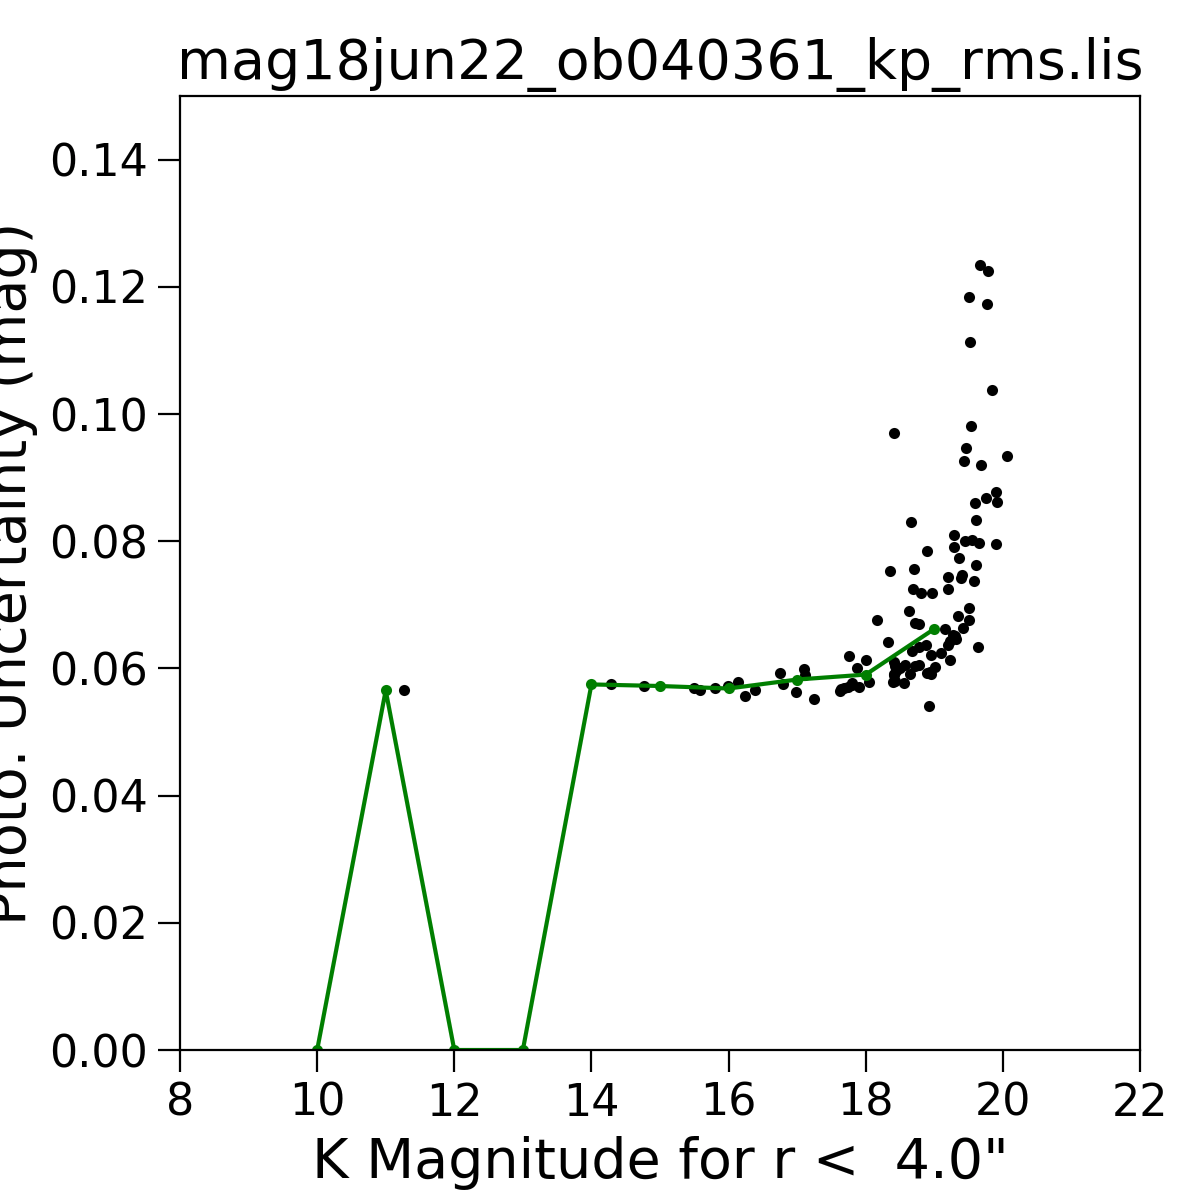

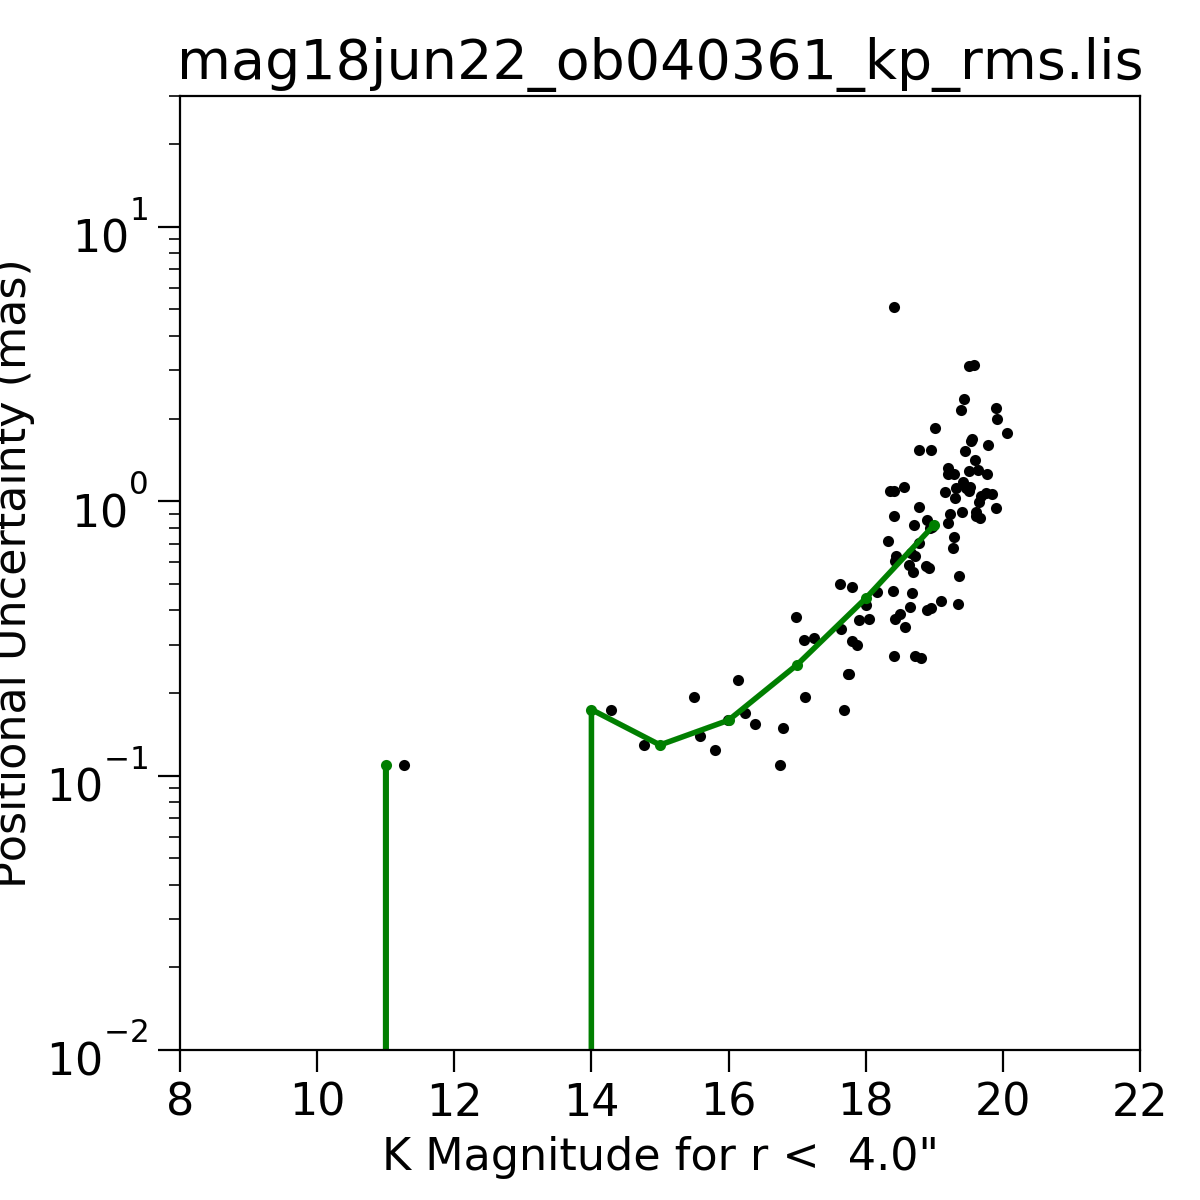

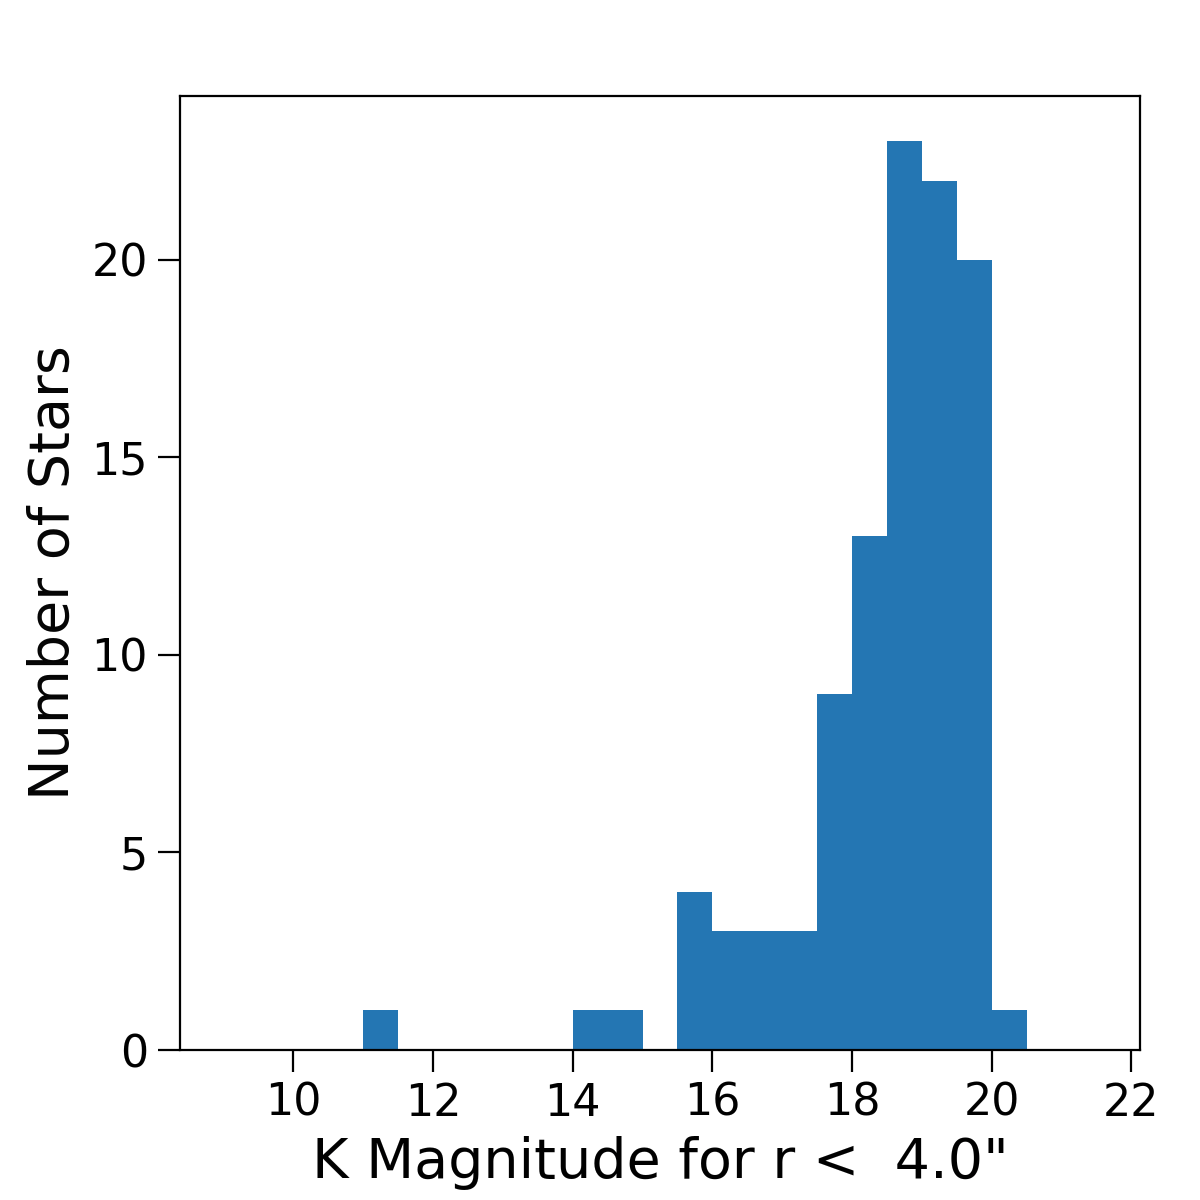

It also gives us some new .fits files in the `combo/` folder, namely:
* _psf.fits - the extracted psf by starfinder, can be checked to see if starfinder performed alright.  

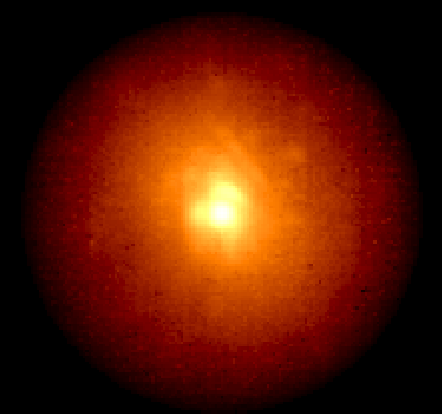

* _res.fits - the residual of the original combined .fits file, after subtracting the extracted psfs out. This should indicate if there is any other source in the image, or hidden in the star's brightness, that starfinder was unable to detect.  

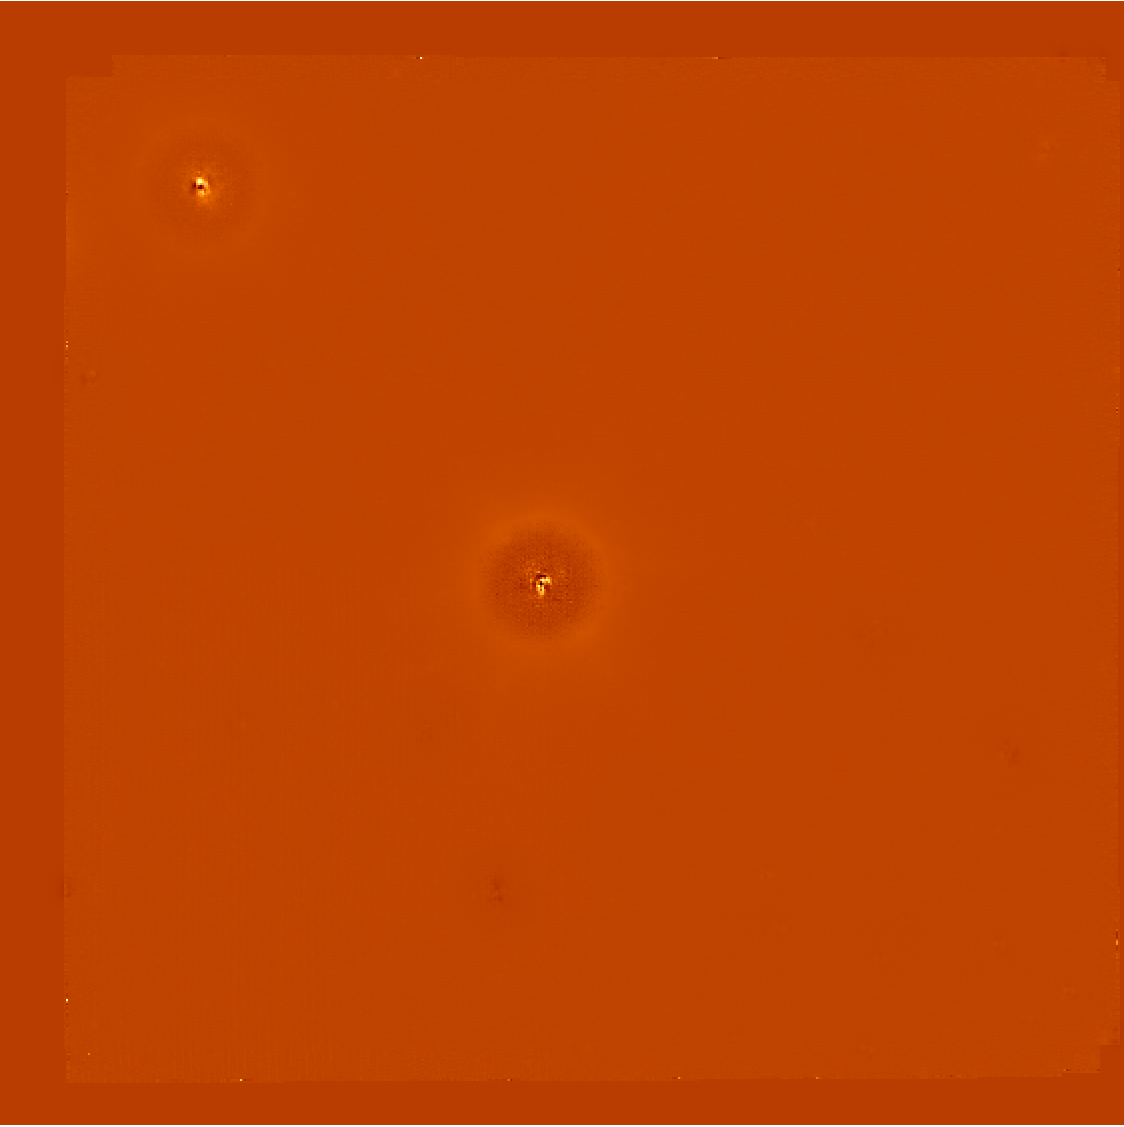

* _stars.fits - the original .fits file, except without all the noise as if each star were a perfect, extracted psf.  

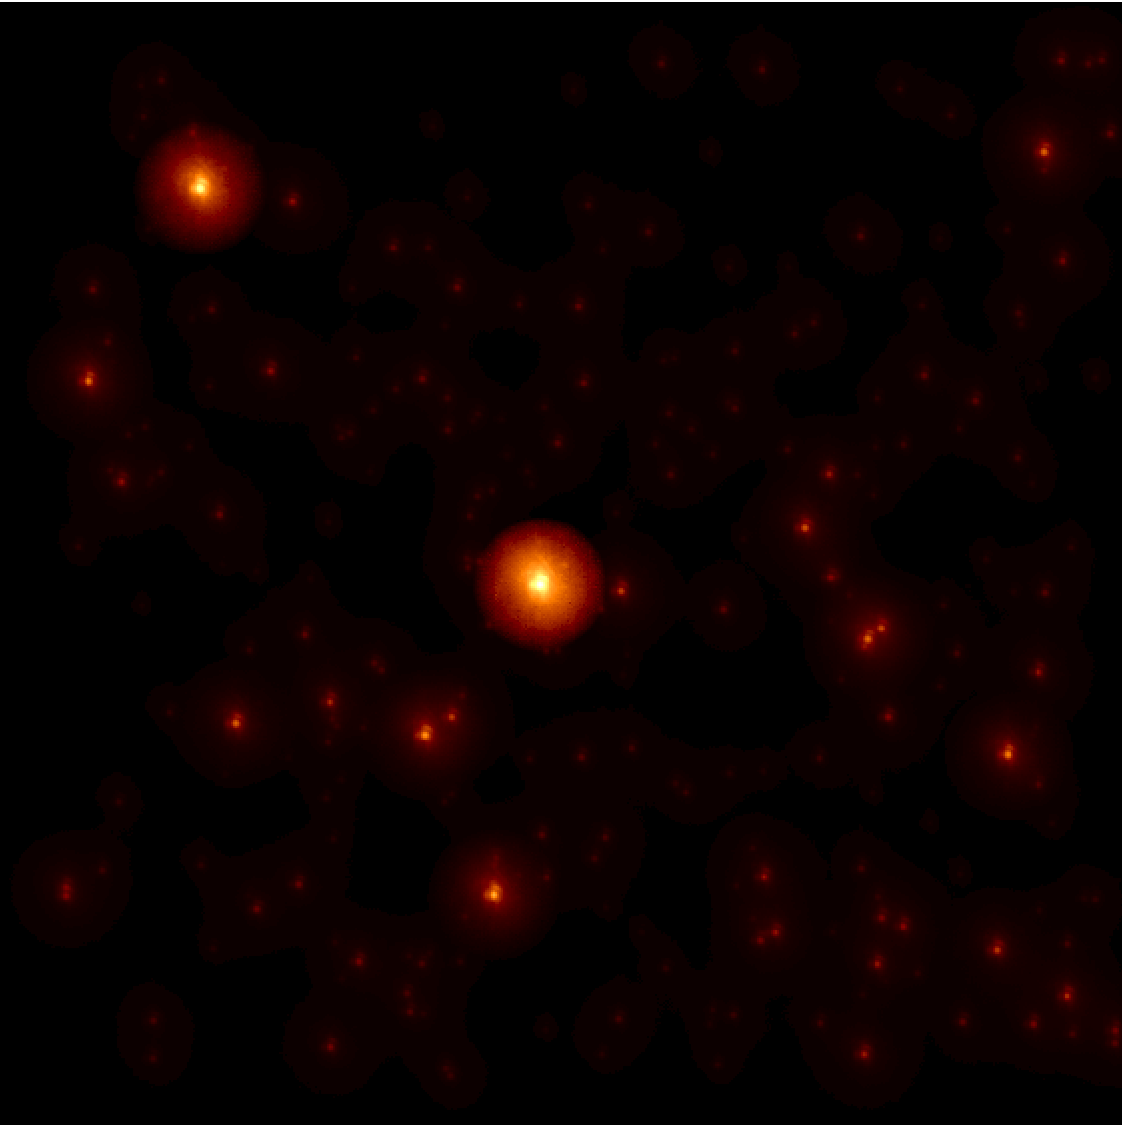

* _back.fits - estimated background image, not quite a flat, but close.
* _sig.fits - ???

That concludes the data analysis process - as a quick summary, we got the raw data from Keck, extracted and reduced that data by subtracting our skies, darks, flats and other pixel masks from a combined set of target frames. Finally, we used starfinder on this image to extract the PSF and locate all stars. With this, we were able output their photometric and astrometric data, their respective error bars, and the residual images of the star.